<a href="https://colab.research.google.com/github/nail1021734/stock_example/blob/main/stock_autoregressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 為了讓可以讓模型自己預測未來 n 天的股價波動，
# 這裡使用多個 Linear regression model，每個 model 學習預測明天的某個特徵

# 安裝套件
!pip install yfinance
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install pandas

In [62]:
# 從yahoo股市蒐集資料
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
yf.pdr_override()

# 指定公司
stock_name = '2330.TW'
# 指定訓練資料日期範圍 (從20200101開始至今)
start_date = datetime(2020, 1, 1)
end_date = None

# 透過api從yahoo股市下載指定公司資料
data = pdr.get_data_yahoo(stock_name, start=start_date, end=end_date).reset_index()
data.set_index('Date', inplace=True)

# 在colab界面輸出資料
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,332.5,339.0,332.5,339.0,313.791626,31754120
2020-01-03,344.0,345.0,335.5,339.5,314.254456,41811268
2020-01-06,333.0,334.5,332.0,332.0,307.312103,45343057
2020-01-07,332.5,333.0,326.5,329.5,304.998047,50879181
2020-01-08,325.0,333.0,325.0,329.5,304.998047,37567748
...,...,...,...,...,...,...
2023-06-15,590.0,593.0,587.0,591.0,591.000000,27392154
2023-06-16,590.0,590.0,584.0,589.0,589.000000,38128802
2023-06-19,583.0,585.0,582.0,583.0,583.000000,14346885


Open 訓練資料MSE: 48.732674536253874
Open 測試資料MSE: 66.47105613112954 

High 訓練資料MSE: 52.660275600677735
High 測試資料MSE: 71.36149124039194 

Low 訓練資料MSE: 49.21932513143149
Low 測試資料MSE: 62.97653421119603 

Close 訓練資料MSE: 70.34108944804044
Close 測試資料MSE: 88.40746475524487 

Adj Close 訓練資料MSE: 64.2987971408157
Adj Close 測試資料MSE: 86.15208314115459 



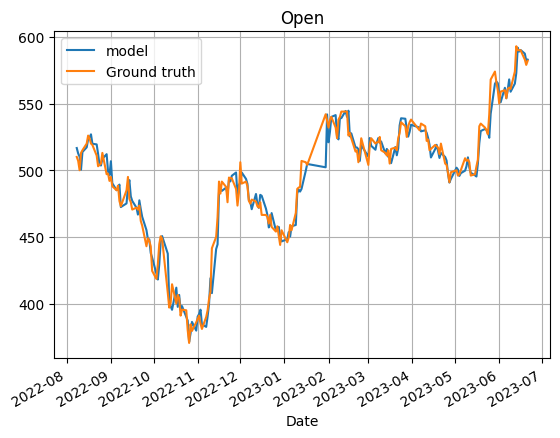

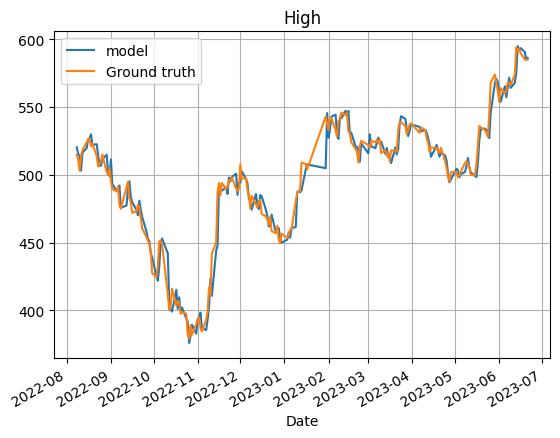

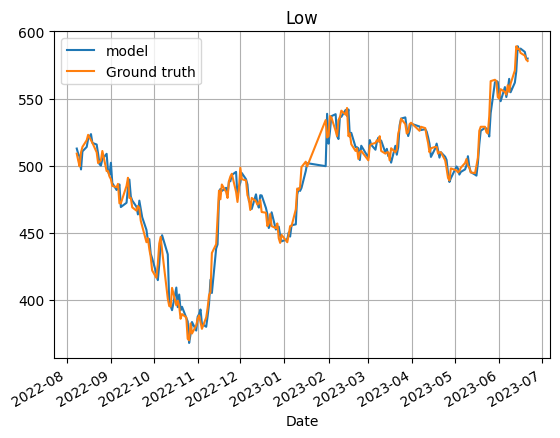

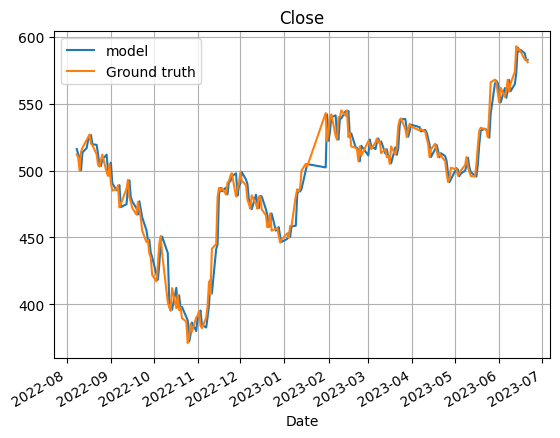

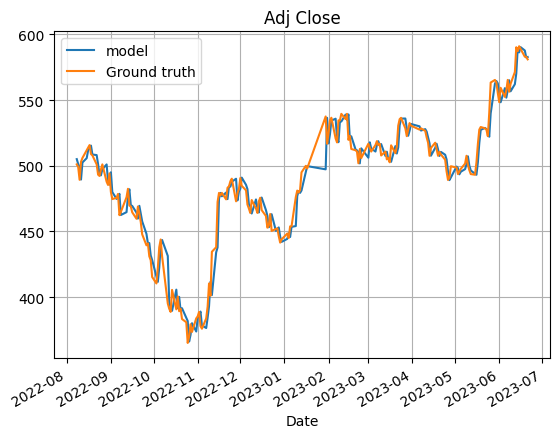

In [63]:
from sklearn.linear_model import LinearRegression
import pandas as pd

models = {
    'Open': None,
    'High': None,
    'Low': None,
    'Close': None,
    'Adj Close': None,
    # 'Volume': None,
}

# 75％ 的資料用於訓練，25％ 的資料用於測試
split_ratio = 0.75
# 由於測試結果成交量難以進行準確預測，因此不使用交易量作為輸入特徵
# x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']][:-1].to_numpy()
x = data[['Open', 'High', 'Low', 'Close', 'Adj Close']][:-1].to_numpy()
for col in models.keys():
    y = data[col][1:].to_numpy()

    # 分割資料 (分割時照日期新舊排序, 最新的25％會做為測試資料)
    x_train = x[:int(split_ratio*len(x))]
    y_train = y[:int(split_ratio*len(x))].reshape(-1, 1)
    x_test = x[int(split_ratio*len(x)):]
    y_test = y[int(split_ratio*len(x)):].reshape(-1, 1)

    # 建立模型
    models[col] = LinearRegression()
    # 訓練模型
    models[col] = models[col].fit(x_train, y_train)

    # 計算訓練完的模型於訓練資料的 Mean squared error
    train_x_pred = models[col].predict(x_train)
    train_mse = (train_x_pred - y_train).T@(train_x_pred - y_train) / y_train.shape[0]
    print(f"{col} 訓練資料MSE:", train_mse[0][0])
    # 計算訓練完的模型於訓練資料的 Mean squared error
    test_x_pred = models[col].predict(x_test)
    test_mse = (test_x_pred - y_test).T@(test_x_pred - y_test) / y_test.shape[0]
    print(f"{col} 測試資料MSE:", test_mse[0][0], '\n')

    # 將測試結果呈現於圖上
    predict_test = models[col].predict(x_test)
    df = pd.DataFrame(predict_test, columns=['model'], index=data.index[1:][int(len(x)*split_ratio):])
    df['Ground truth'] = y_test
    ax = df.plot(grid=True, legend=True)
    ax.set_title(col)


In [64]:
import numpy as np
# 預測未來 10 天
n = 10
# 輸入 6/21 日的[開盤, 最高, 最低, 收盤, 調整收盤假]後 n 天的各個特徵
infr_x = np.array([582, 585, 578, 581, 581]).reshape(1, -1)
# infr_x = np.array([582, 585, 578, 581, 581, 21703937]).reshape(1, -1)
result = []
for i in range(n):
    tmp = {k: None for k in models.keys()}
    for col in models.keys():
        tmp[col] = models[col].predict(infr_x)[0][0]

    print(f"起始日後 {i+1} 日", tmp)
    result.append(tmp)
    # 將輸入更新為預測結果
    infr_x = np.array([
        tmp['Open'],
        tmp['High'],
        tmp['Low'],
        tmp['Close'],
        tmp['Adj Close'],
        # tmp['Volume'],
    ]).reshape(1, -1)

起始日後 1 日 {'Open': 580.2497726479776, 'High': 583.8742280342215, 'Low': 577.138697214327, 'Close': 580.4979807591071, 'Adj Close': 580.5041657537124}
起始日後 2 日 {'Open': 579.8916527034605, 'High': 583.423669285492, 'Low': 576.7934237963995, 'Close': 580.0436340556902, 'Adj Close': 580.0552949792998}
起始日後 3 日 {'Open': 579.426438417717, 'High': 582.9343270491406, 'Low': 576.3463751033149, 'Close': 579.5834061099011, 'Adj Close': 579.601089783428}
起始日後 4 日 {'Open': 578.9645675624467, 'High': 582.460280380247, 'Low': 575.8938517872159, 'Close': 579.1209205306108, 'Adj Close': 579.1446972735232}
起始日後 5 日 {'Open': 578.5022878719026, 'High': 581.9915944060654, 'Low': 575.4374036141933, 'Close': 578.6587367609541, 'Adj Close': 578.6885918082066}
起始日後 6 日 {'Open': 578.0411059355213, 'High': 581.5264006101311, 'Low': 574.980573472622, 'Close': 578.1977651475498, 'Adj Close': 578.2336396491501}
起始日後 7 日 {'Open': 577.581470697781, 'High': 581.0637659390363, 'Low': 574.5246570043657, 'Close': 577.7383

日期區間 2022-08-08 00:00:00 ~ 2023-06-21 00:00:00


<Axes: xlabel='Date'>

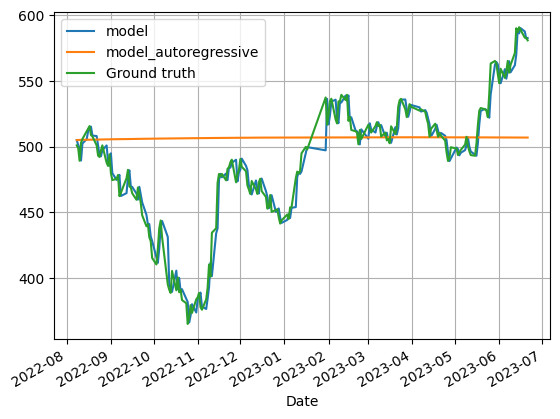

In [65]:
# 在測試資料上比較 autoregressive model 的效果
import pandas as pd

n = x_test.shape[0]
# 輸入 6/21 日的[開盤, 最高, 最低, 收盤, 調整收盤假]後 n 天的各個特徵
infr_x = x_test[0].reshape(1, -1)
# infr_x = np.array([582, 585, 578, 581, 581, 21703937]).reshape(1, -1)
result = []
for i in range(n):
    tmp = {k: None for k in models.keys()}
    for col in models.keys():
        tmp[col] = models[col].predict(infr_x)[0][0]

    # print(f"起始日後 {i+1} 日", tmp)
    result.append(tmp)
    # 將輸入更新為預測結果
    infr_x = np.array([
        tmp['Open'],
        tmp['High'],
        tmp['Low'],
        tmp['Close'],
        tmp['Adj Close'],
        # tmp['Volume'],
    ]).reshape(1, -1)


predict_test = models['Adj Close'].predict(x_test)
predict_test_autoregressive = [i['Adj Close'] for i in result]
# 於測試資料上的圖表比較
df = pd.DataFrame(predict_test, columns=['model'], index=data.index[1:][int(len(x)*split_ratio):])
df['model_autoregressive'] = predict_test_autoregressive
df['Ground truth'] = y_test
print('日期區間', list(data.index[1:][int(len(x)*split_ratio):])[0], "~", list(data.index[1:][int(len(x)*split_ratio):])[-1])

df.plot(grid=True, legend=True)

# 圖中 model 為根據前一天資料預測後一天的預測結果
# model_autoregressive 只使用第一天的資料預測後續 n 天的結果
# 可以看出來 auto regressive 的效果並不好，
# 應該是 Linear regression 模型只能學線性函數的關係，
# 還是看前一天預測後一天的效果比較準確